In [2]:
import sys
sys.path.append('C:\\Users\\mohini\\Documents\\LoadModelingAndAgg\\pecan_street\\PecanPy\\examples')

import datetime as dat
from datetime import timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pecanpy
import scipy.stats as stats
import numpy.random as random

%matplotlib inline
plt.style.use("ggplot")

In [3]:
# define user credentials
USER_NAME = 'NqcehxzG8kY4'
PASSWORD = 'V7Zicww85iLT'

# define db server params
SCHEMA = 'university'
HOST = 'dataport.cloud'
PORT = '5434'
DB = 'postgres'

# create the engine that connects to the database...
engine = pecanpy.create_engine(USER_NAME, PASSWORD, HOST, PORT, DB)

In [4]:
with engine.connect() as con:
    metadata_df = pecanpy.read_metadata_table(con, schema=SCHEMA)
[nHomes, nAttribs] = metadata_df.shape
print("Number of homes: " + str(nHomes))

Number of homes: 1436


In [29]:
with_egauge_data = metadata_df[metadata_df.egauge_min_time.notnull()]

In [54]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
with_times = metadata_df[metadata_df.egauge_min_time < start_time]
with_times = with_times[with_times.egauge_max_time > end_time]
print(with_times.shape)

(426, 103)


# Experiment 1
## Variance of load over time vs. aggregation level

In [129]:
def getAggLoad(nAgg, homes, start_time, end_time, rez='H'):
    dataCount = 0
    for home in homes:
        with engine.connect() as con:
            # Query data
            homeload = pecanpy.read_electricity_egauge_query(con, SCHEMA, home, start_time, end_time, "all", rez)
            load = homeload['use']
            bad = load.isnull().values.any() or load.empty
            if not bad:
                if dataCount==0:
                    totalLoad = load
                else:
                    totalLoad = totalLoad + load
                dataCount = dataCount + 1;
    return totalLoad, dataCount

def getNLoads(N, homes, start_time, end_time, rez='H'):
    dataCount = 0;
    idx = 0;
    numHomes = np.size(homes)
    while dataCount < N and idx < numHomes:
        with engine.connect() as con:
            home = homes[idx]
            homeload = pecanpy.read_electricity_egauge_query(con, SCHEMA, home, start_time, end_time, "all", rez)
            load = homeload['use']
            bad = load.isnull().values.any() or load.empty
            if not bad:
                if dataCount==0:
                    allLoads = load
                else:
                    allLoads = pd.concat([allLoads, load], axis=1)
                dataCount = dataCount + 1
            idx = idx + 1;
    return allLoads

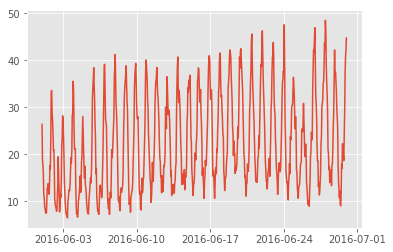

In [64]:
nAgg = 10
homes = with_times.sample(n=nAgg)
homes = homes.index

# Choose starting time and ending time
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)

# Get 1 hour resolution data for the homes
totalLoad = getAggLoad(nAgg, homes, start_time, end_time)
plt.plot(totalLoad)

In [93]:
# Choose starting time and ending time
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,2,0,0, tzinfo=timezone.utc)

aggLevels = np.arange(1, 50, 5)
T = np.size(aggLevels)
loadVar = np.zeros(T)
meanLoadVar = np.zeros(T)
cV = np.zeros(T)
cV_mean = np.zeros(T)

nHomes = np.zeros(T)


for i in range(T):
    nAgg = aggLevels[i]
    print("Aggregation Level: " + str(nAgg))
    homes = with_times.sample(n=nAgg)
    homes = homes.index
    
    totalLoad, nAgg_real = getAggLoad(nAgg, homes, start_time, end_time, rez='T')
    meanLoad = totalLoad / nAgg_real
    
    nHomes[i] = nAgg_real
    
    loadVar[i] = np.var(totalLoad)
    meanLoadVar[i] = np.var(meanLoad)
    cV[i] = stats.variation(totalLoad)
    cV_mean[i] = stats.variation(meanLoad)

Aggregation Level: 1
Aggregation Level: 6
Aggregation Level: 11
Aggregation Level: 16
Aggregation Level: 21
Aggregation Level: 26
Aggregation Level: 31
Aggregation Level: 36
Aggregation Level: 41
Aggregation Level: 46


Text(0.5,1,'Coeff. of variation of mean load')

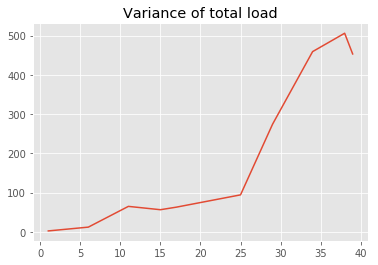

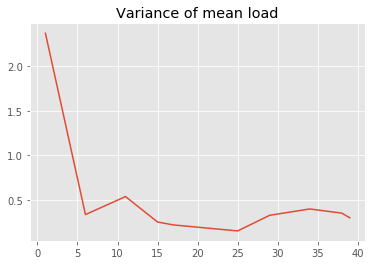

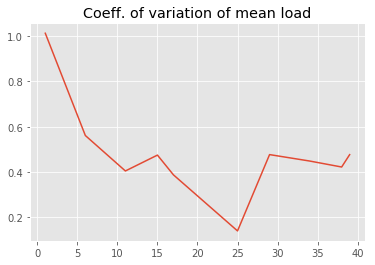

In [98]:
# Sort by number of homes
sorted_idxs = np.argsort(nHomes)

plt.figure(); plt.plot(nHomes[sorted_idxs], loadVar[sorted_idxs]); plt.title('Variance of total load')
plt.figure(); plt.plot(nHomes[sorted_idxs], meanLoadVar[sorted_idxs]); plt.title('Variance of mean load')
plt.figure(); plt.plot(nHomes[sorted_idxs], cV_mean[sorted_idxs]); plt.title('Coeff. of variation of mean load')

In [135]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,2,0,0, tzinfo=timezone.utc)
N = 20; 

loads_20_df = getNLoads(N, with_times.index, start_time, end_time, rez='T')

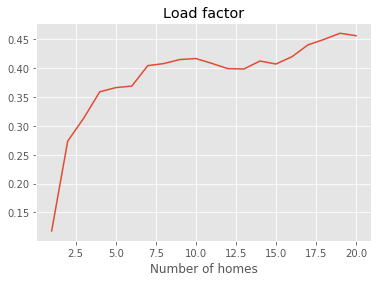

In [141]:
loads_20 = loads_20_df.values;

aggloads_20 = np.cumsum(loads_20, axis=1)
maxload_20 = np.max(aggloads_20, axis=0)
meanload_20 = np.mean(aggloads_20, axis=0)

load_fac = meanload_20 / maxload_20
plt.figure(); plt.plot(np.arange(1, 21), load_fac); 
plt.xlabel('Number of homes')
plt.title('Load factor');

In [143]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
N = 20; 

hourlyloads_20_df = getNLoads(N, with_times.index, start_time, end_time, rez='H')